# Detrend model data
- This is a data pre-processing notebook
- We will read CESM2 LENS daily temperature data (max,min and mean) and detrend it

In [56]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mtplt
import glob
import intake
import zarr
import nc_time_axis
#import xskillscore as xs
import cartopy as cart
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from datetime import datetime, timedelta
import pandas as pd

In [57]:
import dask 
from dask_jobqueue import PBSCluster
from dask.distributed import Client
from dask.distributed import performance_report

In [58]:
chic_lat  = 41.8781
chic_lon  = (360-87.6298)%360
ben_lat   = 12.9716
ben_lon   = 77.5946
########## CONUS ############
#CONUS lat-lon
top       = 50.0 # north lat
left      = -124.7844079+360 # west long
right     = -66.9513812+360 # east long
bottom    =  24.7433195 # south lat
################################
rda_scratch = '/gpfs/csfs1/collections/rda/scratch/harshah'
catalog_url = 'https://data.rda.ucar.edu/harshah/intake_catalogs/posix/cesm2-lens/rda-cesm2-lens-posix.json'
rda_data    = '/gpfs/csfs1/collections/rda/data/harshah/'
###
tmean_path  = rda_data + 'mdm_data/tmean/'
tmax_path   = rda_data + 'mdm_data/tmax/'
tmin_path   = rda_data + 'mdm_data/tmin/'
############
pi_year  = 1865
eoc_year = 2085
#
pi_year0  = '1850'
pi_year1  = '1879'
ic_year0  = '2071'
ic_year1  = '2100'
doy       = 211 # day_of_year

In [59]:
def no_leap_date(day_of_year):
    # Start from the first day of a non-leap year
    start_date = datetime(2021, 1, 1)

    # Calculate the actual date (subtract 1 because January 1st is day 1)
    actual_date = start_date + timedelta(days=day_of_year - 1)

    # Format the date to get 'Month Day'
    return actual_date.strftime('%B %d')
###############################
date = no_leap_date(doy)

In [60]:
def to_daily(ds):
    year       = ds.time.dt.year
    dayofyear  = ds.time.dt.dayofyear

    # assign new coords
    ds = ds.assign_coords(year=("time", year.data), dayofyear=("time", dayofyear.data))

    # reshape the array to (..., "day", "year")
    return ds.set_index(time=("year", "dayofyear")).unstack("time") 

In [61]:
def detrend_all(ds, central_year):
    # Assumes that the ds has coordinates day, year and member.
    
    #Fit a linear fuction and extract slope
    pcoeffs = ds.mean('member_id').polyfit(dim='year',deg=1)
    #print(pcoeffs)
    slope   = pcoeffs.polyfit_coefficients.sel(degree=1)
    
    #Calculate trend
    ds_trend   = slope*(ds['year']- central_year)
    
    #Detrend by subtracting the trend from the data
    ds_detrended = ds  - ds_trend
    
    return ds_detrended

In [62]:
def implement_mdm(ds_obs,init_mean,final_mean,init_std,final_std):
    # Assuming coordinates year and day for ds_obs
    obs_mean = ds_obs.mean('year')
    sratio   = final_std/init_std
    ds_mdm   = obs_mean + (final_mean - init_mean) + sratio*(ds_obs - obs_mean)        
    return ds_mdm

def implement_qdm(qobs, qinit, qfinal):
    # Implement quantile delta mapping. Assumes model data has corrd called 'mtime'
    #qinit    = init_data.quantile(quants,dim='mtime')
    #qfinal   = final_data.quantile(quants,dim='mtime')
    ds_qdm   = qobs + (qfinal - qinit)
    return ds_qdm

def is_sorted(arr):
    return np.all(arr[:-1] <= arr[1:]) or np.all(arr[:-1] >= arr[1:])

#
quants = np.linspace(0,1.0,30)
def compute_quantiles(ds, quantiles=quants):
    return ds.chunk(dict(year=-1)).quantile(quantiles, dim='year',skipna=False)

In [63]:
# Create a PBS cluster object
cluster = PBSCluster(
    job_name = 'dask-wk24-hpc',
    cores = 1,
    memory = '8GiB',
    processes = 1,
    local_directory = rda_scratch+'/dask/spill',
    log_directory = rda_scratch + '/dask/logs/',
    resource_spec = 'select=1:ncpus=1:mem=8GB',
    queue = 'casper',
    walltime = '5:00:00',
    #interface = 'ib0'
    interface = 'ext'
)

In [64]:
cluster

Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/harshah/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.97:45853,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/harshah/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [65]:
cluster.scale(12)

In [66]:
# cluster

## Load CESM2 LENS zarr data

In [67]:
# Open collection description file using intake
col         = intake.open_esm_datastore(catalog_url)
col

,unique
Unnamed: 0,322
variable,53
long_name,51
component,4
experiment,2
forcing_variant,2
frequency,3
vertical_levels,3
spatial_domain,3
units,20


In [68]:
mean_temps = col.search(variable ='TREFHT', frequency ='daily')
mean_temps

,unique
Unnamed: 0,4
variable,1
long_name,1
component,1
experiment,2
forcing_variant,2
frequency,1
vertical_levels,1
spatial_domain,1
units,1


### Detrend daily mean temperatures

In [69]:
ds_tmean = mean_temps.to_dataset_dict()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency.forcing_variant'


In [70]:
ds_tmean.keys()

dict_keys(['atm.ssp370.daily.cmip6', 'atm.historical.daily.cmip6', 'atm.ssp370.daily.smbb', 'atm.historical.daily.smbb'])

In [71]:
dsmean_pi_cmip6 = ds_tmean['atm.historical.daily.cmip6'].TREFHT.sel(time=slice(pi_year0,pi_year1))
dsmean_pi_smbb  = ds_tmean['atm.historical.daily.smbb'].TREFHT.sel(time=slice(pi_year0,pi_year1))
# dsmean_pi_smbb
dsmean_eoc_cmip6 = ds_tmean['atm.ssp370.daily.cmip6'].TREFHT.sel(time=slice(ic_year0,ic_year1))
dsmean_eoc_smbb  = ds_tmean['atm.ssp370.daily.smbb'].TREFHT.sel(time=slice(ic_year0,ic_year1))

In [72]:
%%time
# Merge datasets to obtain pre-industrial and EOC daily mean temperatures
pi_tmeans  = xr.concat([dsmean_pi_cmip6,dsmean_pi_smbb],dim='member_id')
eoc_tmeans = xr.concat([dsmean_eoc_cmip6,dsmean_eoc_smbb],dim='member_id')

CPU times: user 21.4 ms, sys: 4.51 ms, total: 25.9 ms
Wall time: 50.1 ms


In [73]:
pi_tmean_daily  = to_daily(pi_tmeans)
eoc_tmean_daily = to_daily(eoc_tmeans)
pi_tmean_daily  = pi_tmean_daily.chunk({'lat':48,'year':30,'dayofyear':30})
eoc_tmean_daily = eoc_tmean_daily.chunk({'lat':48,'year':30,'dayofyear':30})

In [74]:
%%time
# pi_tmean_daily.to_dataset().to_zarr(tmean_path +'pre_ind_daily_mean.zarr',mode='w')
# eoc_tmean_daily.to_dataset().to_zarr(tmean_path +'eoc_daily_mean.zarr',mode='w')

CPU times: user 2 μs, sys: 0 ns, total: 2 μs
Wall time: 4.53 μs


In [75]:
%%time
pi_tmean_daily  = xr.open_zarr(tmean_path +'pre_ind_daily_mean.zarr').TREFHT
eoc_tmean_daily = xr.open_zarr(tmean_path +'eoc_daily_mean.zarr').TREFHT

CPU times: user 29.2 ms, sys: 1.87 ms, total: 31 ms
Wall time: 33.1 ms


In [76]:
pi_tmean_detrended  = detrend_all(pi_tmean_daily,pi_year)
eoc_tmean_detrended = detrend_all(eoc_tmean_daily,eoc_year)
#
pi_tmean_detrended  = pi_tmean_detrended.rename('detrended_tmean')
eoc_tmean_detrended = eoc_tmean_detrended.rename('detrended_tmean')

In [77]:
# %%time
# pi_tmean_detrended.to_dataset().to_zarr(tmean_path +'pre_ind_detrended.zarr',mode='w')
# eoc_tmean_detrended.to_dataset().to_zarr(tmean_path +'eoc_detrended.zarr',mode='w')

#### Check if detrending worked

In [78]:
pi_tmean_detrended  = xr.open_zarr(tmean_path +'pre_ind_detrended.zarr').detrended_tmean
eoc_tmean_detrended = xr.open_zarr(tmean_path +'eoc_detrended.zarr').detrended_tmean

CPU times: user 4.86 s, sys: 5.12 s, total: 9.99 s
Wall time: 32.6 s


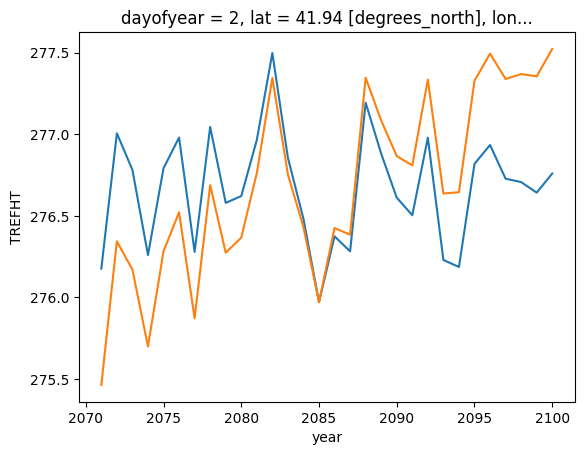

In [79]:
%%time
eoc_tmean_detrended.sel(lat=chic_lat,lon=chic_lon,method='nearest').sel(dayofyear=2).mean('member_id').plot()
eoc_tmean_daily.sel(lat=chic_lat,lon=chic_lon,method='nearest').sel(dayofyear=2).mean('member_id').plot()

CPU times: user 4.77 s, sys: 4.92 s, total: 9.68 s
Wall time: 28.7 s


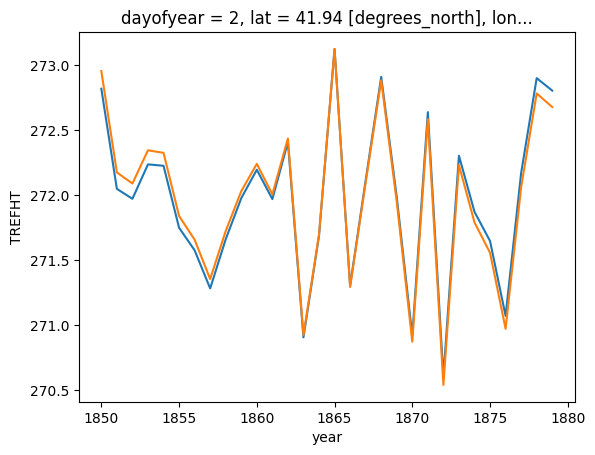

In [80]:
%%time
pi_tmean_detrended.sel(lat=chic_lat,lon=chic_lon,method='nearest').sel(dayofyear=2).mean('member_id').plot()
pi_tmean_daily.sel(lat=chic_lat,lon=chic_lon,method='nearest').sel(dayofyear=2).mean('member_id').plot()

### Detrend daily max temperatures

In [81]:
max_temps = col.search(variable ='TREFHTMX', frequency ='daily')
# max_temps

In [82]:
ds_tmax = max_temps.to_dataset_dict()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency.forcing_variant'


In [83]:
ds_tmax.keys()

dict_keys(['atm.ssp370.daily.cmip6', 'atm.historical.daily.cmip6', 'atm.ssp370.daily.smbb', 'atm.historical.daily.smbb'])

In [84]:
dsmax_pi_cmip6 = ds_tmax['atm.historical.daily.cmip6'].TREFHTMX.sel(time=slice(pi_year0,pi_year1))
dsmax_pi_smbb  = ds_tmax['atm.historical.daily.smbb'].TREFHTMX.sel(time=slice(pi_year0,pi_year1))
# dsmax_pi_smbb
dsmax_eoc_cmip6 = ds_tmax['atm.ssp370.daily.cmip6'].TREFHTMX.sel(time=slice(ic_year0,ic_year1))
dsmax_eoc_smbb  = ds_tmax['atm.ssp370.daily.smbb'].TREFHTMX.sel(time=slice(ic_year0,ic_year1))

In [85]:
%%time
# Merge datasets to obtain pre-industrial and EOC daily mean temperatures
pi_tmax  = xr.concat([dsmax_pi_cmip6,dsmax_pi_smbb],dim='member_id')
eoc_tmax = xr.concat([dsmax_eoc_cmip6,dsmax_eoc_smbb],dim='member_id')

CPU times: user 15.5 ms, sys: 8.27 ms, total: 23.8 ms
Wall time: 28.9 ms


In [86]:
pi_tmax_daily  = to_daily(pi_tmax)
eoc_tmax_daily = to_daily(eoc_tmax)
pi_tmax_daily  = pi_tmax_daily.chunk({'lat':48,'year':30,'dayofyear':30})
eoc_tmax_daily = eoc_tmax_daily.chunk({'lat':48,'year':30,'dayofyear':30})

In [87]:
# %%time
# pi_tmax_daily.to_dataset().to_zarr(tmax_path +'pre_ind_daily_max.zarr',mode='w')
# eoc_tmax_daily.to_dataset().to_zarr(tmax_path +'eoc_daily_max.zarr',mode='w')

In [88]:
%%time
pi_tmax_daily  = xr.open_zarr(tmax_path +'pre_ind_daily_max.zarr').TREFHTMX
eoc_tmax_daily = xr.open_zarr(tmax_path +'eoc_daily_max.zarr').TREFHTMX

CPU times: user 26.3 ms, sys: 2.29 ms, total: 28.6 ms
Wall time: 35 ms


In [89]:
pi_tmax_detrended  = detrend_all(pi_tmax_daily,pi_year)
eoc_tmax_detrended = detrend_all(eoc_tmax_daily,eoc_year)
#
pi_tmax_detrended  = pi_tmax_detrended.rename('detrended_tmax')
eoc_tmax_detrended = eoc_tmax_detrended.rename('detrended_tmax')

In [90]:
# %%time
# pi_tmax_detrended.to_dataset().to_zarr(tmax_path +'pre_ind_detrended_tmax.zarr',mode='w')

In [91]:
# %%time
# eoc_tmax_detrended.to_dataset().to_zarr(tmax_path +'eoc_detrended_tmax.zarr',mode='w')

#### Check if detrending worked

In [92]:
pi_tmax_detrended  = xr.open_zarr(tmax_path +'pre_ind_detrended_tmax.zarr').detrended_tmax
eoc_tmax_detrended = xr.open_zarr(tmax_path +'eoc_detrended_tmax.zarr').detrended_tmax

CPU times: user 4.88 s, sys: 4.93 s, total: 9.81 s
Wall time: 27 s


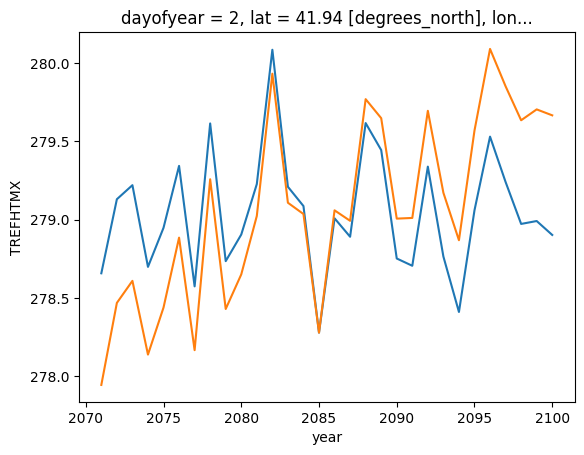

In [93]:
%%time
eoc_tmax_detrended.sel(lat=chic_lat,lon=chic_lon,method='nearest').sel(dayofyear=2).mean('member_id').plot()
eoc_tmax_daily.sel(lat=chic_lat,lon=chic_lon,method='nearest').sel(dayofyear=2).mean('member_id').plot()

CPU times: user 4.56 s, sys: 5.04 s, total: 9.59 s
Wall time: 27.1 s


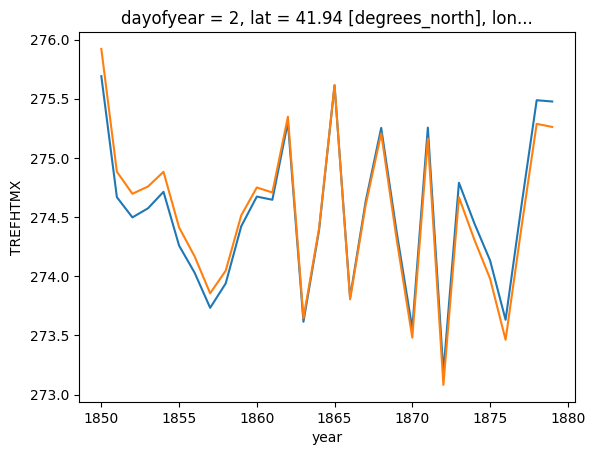

In [94]:
%%time
pi_tmax_detrended.sel(lat=chic_lat,lon=chic_lon,method='nearest').sel(dayofyear=2).mean('member_id').plot()
pi_tmax_daily.sel(lat=chic_lat,lon=chic_lon,method='nearest').sel(dayofyear=2).mean('member_id').plot()

### Detrend daily min temperatures

In [95]:
min_temps = col.search(variable ='TREFHTMN', frequency ='daily')
min_temps

,unique
Unnamed: 0,4
variable,1
long_name,1
component,1
experiment,2
forcing_variant,2
frequency,1
vertical_levels,1
spatial_domain,1
units,1


In [96]:
ds_tmin = min_temps.to_dataset_dict()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency.forcing_variant'


In [97]:
ds_tmin.keys()

dict_keys(['atm.ssp370.daily.cmip6', 'atm.historical.daily.cmip6', 'atm.ssp370.daily.smbb', 'atm.historical.daily.smbb'])

In [98]:
dsmin_pi_cmip6 = ds_tmin['atm.historical.daily.cmip6'].TREFHTMN.sel(time=slice(pi_year0,pi_year1))
dsmin_pi_smbb  = ds_tmin['atm.historical.daily.smbb'].TREFHTMN.sel(time=slice(pi_year0,pi_year1))
# dsmax_pi_smbb
dsmin_eoc_cmip6 = ds_tmin['atm.ssp370.daily.cmip6'].TREFHTMN.sel(time=slice(ic_year0,ic_year1))
dsmin_eoc_smbb  = ds_tmin['atm.ssp370.daily.smbb'].TREFHTMN.sel(time=slice(ic_year0,ic_year1))

In [99]:
%%time
# Merge datasets to obtain pre-industrial and EOC daily mean temperatures
pi_tmin  = xr.concat([dsmin_pi_cmip6,dsmin_pi_smbb],dim='member_id')
eoc_tmin = xr.concat([dsmin_eoc_cmip6,dsmin_eoc_smbb],dim='member_id')

CPU times: user 20 ms, sys: 1.46 ms, total: 21.5 ms
Wall time: 30.3 ms


In [100]:
pi_tmin_daily  = to_daily(pi_tmin)
eoc_tmin_daily = to_daily(eoc_tmin)
pi_tmin_daily  = pi_tmin_daily.chunk({'lat':48,'year':30,'dayofyear':30})
eoc_tmin_daily = eoc_tmin_daily.chunk({'lat':48,'year':30,'dayofyear':30})

In [101]:
# %%time
# pi_tmin_daily.to_dataset().to_zarr(tmin_path +'pre_ind_daily_min.zarr',mode='w')
# eoc_tmin_daily.to_dataset().to_zarr(tmin_path +'eoc_daily_min.zarr',mode='w')

In [102]:
%%time
pi_tmin_daily  = xr.open_zarr(tmin_path +'pre_ind_daily_min.zarr').TREFHTMN
eoc_tmin_daily = xr.open_zarr(tmin_path +'eoc_daily_min.zarr').TREFHTMN

CPU times: user 30.3 ms, sys: 0 ns, total: 30.3 ms
Wall time: 31.5 ms


In [103]:
pi_tmin_detrended  = detrend_all(pi_tmin_daily,pi_year)
eoc_tmin_detrended = detrend_all(eoc_tmin_daily,eoc_year)
#
pi_tmin_detrended  = pi_tmin_detrended.rename('detrended_tmin')
eoc_tmin_detrended = eoc_tmin_detrended.rename('detrended_tmin')

In [104]:
# %%time
# pi_tmin_detrended.to_dataset().to_zarr(tmin_path +'pre_ind_detrended_tmin.zarr',mode='w')

In [ ]:
%%time
eoc_tmin_detrended.to_dataset().to_zarr(tmin_path +'eoc_detrended_tmin.zarr',mode='w')

#### Check if detrending worked

In [ ]:
pi_tmin_detrended  = xr.open_zarr(tmin_path +'pre_ind_detrended_tmin.zarr').detrended_tmin
eoc_tmin_detrended = xr.open_zarr(tmin_path +'eoc_detrended_tmin.zarr').detrended_tmin

In [ ]:
%%time
eoc_tmin_detrended.sel(lat=chic_lat,lon=chic_lon,method='nearest').sel(dayofyear=2).mean('member_id').plot()
eoc_tmin_daily.sel(lat=chic_lat,lon=chic_lon,method='nearest').sel(dayofyear=2).mean('member_id').plot()

In [ ]:
%%time
pi_tmin_detrended.sel(lat=chic_lat,lon=chic_lon,method='nearest').sel(dayofyear=2).mean('member_id').plot()
pi_tmin_daily.sel(lat=chic_lat,lon=chic_lon,method='nearest').sel(dayofyear=2).mean('member_id').plot()

In [ ]:
###########################################################################################

In [ ]:
cluster.close()